In [485]:
#All the necessary imports used in the code
import pandas as pd
import numpy as np
import re
from collections import defaultdict, Counter
import matplotlib.pyplot as plt
import spacy
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer,WordNetLemmatizer
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.decomposition import PCA
import warnings

In [486]:
#Ignoring all warnings
warnings.filterwarnings('ignore')

In [ ]:
!pip install spacy

In [ ]:
!python -m spacy download en_core_web_sm

## Part 1: Sentence comparison using N-gram

In [489]:
df = pd.read_csv('IMDB.csv')

In [490]:
df.head()

,ID,review
0,1,One of the other reviewers has mentioned that ...
1,2,A wonderful little production. <br /><br />The...
2,3,I thought this was a wonderful way to spend ti...
3,4,Basically there's a family where a little boy ...
4,5,"Petter Mattei's ""Love in the Time of Money"" is..."


In [491]:
df.shape

(620, 2)

In [492]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 620 entries, 0 to 619
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   ID      620 non-null    int64 
 1   review  620 non-null    object
dtypes: int64(1), object(1)
memory usage: 9.8+ KB


In [493]:
#To check for null data in the dataset
df.isnull().any()

ID        False
review    False
dtype: bool

In [494]:
#Checking for duplicate rows across all columns
duplicate_rows = df.duplicated()

#Count the number of duplicate rows
num_duplicate_rows = duplicate_rows.sum()
num_duplicate_rows

0

In [495]:
#Displaying all results
df[['ID', 'review']]

,ID,review
0,1,One of the other reviewers has mentioned that ...
1,2,A wonderful little production. <br /><br />The...
2,3,I thought this was a wonderful way to spend ti...
3,4,Basically there's a family where a little boy ...
4,5,"Petter Mattei's ""Love in the Time of Money"" is..."
...,...,...
615,616,It starts out like a very serious social comme...
616,617,This is my first Deepa Mehta film. I saw the f...
617,618,"All the way though i was thinking to myself ""O..."
618,619,"At 2:37, a high school student commits suicide..."


In [496]:
#Display the first review
df['review'].iloc[0]

"One of the other reviewers has mentioned that after watching just 1 Oz episode you'll be hooked. They are right, as this is exactly what happened with me.<br /><br />The first thing that struck me about Oz was its brutality and unflinching scenes of violence, which set in right from the word GO. Trust me, this is not a show for the faint hearted or timid. This show pulls no punches with regards to drugs, sex or violence. Its is hardcore, in the classic use of the word.<br /><br />It is called OZ as that is the nickname given to the Oswald Maximum Security State Penitentary. It focuses mainly on Emerald City, an experimental section of the prison where all the cells have glass fronts and face inwards, so privacy is not high on the agenda. Em City is home to many..Aryans, Muslims, gangstas, Latinos, Christians, Italians, Irish and more....so scuffles, death stares, dodgy dealings and shady agreements are never far away.<br /><br />I would say the main appeal of the show is due to the fa

In [497]:
'''Removing non-alphanumeric characters, punctuation marks and HTML tags such as <br> </br> as part of cleaning the data. Rest of
the pre-processing tasks like Tokenization, Stop words removal done in further section'''
def preprocess_text(text):
    text = re.sub(r'<.*?>', '', text)  # Remove HTML tags
    text = re.sub(r"[.,?_]",' ', text)     # Replace commas and periods with spaces
    text = re.sub(r'[^\w\s]', '', text)  # Remove punctuation 
    text = re.sub(r'\b\d+\b', '', text)  # Remove standalone numbers
    text = re.sub(r'\b\w*\d\w*\b', '', text)  # Remove sequences with digits
    return text

df['processed_text'] = df['review'].apply(preprocess_text)

In [498]:
#Printing the first review after removal
df['processed_text'].iloc[0]

'One of the other reviewers has mentioned that after watching just  Oz episode youll be hooked  They are right  as this is exactly what happened with me The first thing that struck me about Oz was its brutality and unflinching scenes of violence  which set in right from the word GO  Trust me  this is not a show for the faint hearted or timid  This show pulls no punches with regards to drugs  sex or violence  Its is hardcore  in the classic use of the word It is called OZ as that is the nickname given to the Oswald Maximum Security State Penitentary  It focuses mainly on Emerald City  an experimental section of the prison where all the cells have glass fronts and face inwards  so privacy is not high on the agenda  Em City is home to many  Aryans  Muslims  gangstas  Latinos  Christians  Italians  Irish and more    so scuffles  death stares  dodgy dealings and shady agreements are never far away I would say the main appeal of the show is due to the fact that it goes where other shows woul

In [499]:
# Generate bigrams from the corpus
def generate_bigrams(text):
    tokens = text.split()
    bigrams = [(tokens[i], tokens[i+1]) for i in range(len(tokens)-1)]
    return bigrams

In [500]:
# Creating a bigram frequency dictionary
bigram_freq = defaultdict(Counter)

for text in df['processed_text']:
    bigrams = generate_bigrams(text)
    for w1, w2 in bigrams:
        bigram_freq[w1][w2] += 1

In [501]:
# Calculate bigram probabilities
bigram_prob = defaultdict(dict)
for w1 in bigram_freq:
    total_count = float(sum(bigram_freq[w1].values()))
    for w2 in bigram_freq[w1]:
        bigram_prob[w1][w2] = bigram_freq[w1][w2] / total_count

In [502]:
# Function to calculate the probability of a sentence
def sentence_probability(sentence, bigram_prob):
    sentence = preprocess_text(sentence)
    bigrams = generate_bigrams(sentence)
    prob = 1.0
    for w1, w2 in bigrams:
        if w1 in bigram_prob and w2 in bigram_prob[w1]:
            prob *= bigram_prob[w1][w2]
        else:
            prob *= 1e-6  # Smoothing for unseen bigrams
    return prob

In [503]:
# Test sentences
test_sentence_1 =  "Petter Mattei's 'Love in the Time of Money' is a visually stunning film to watch."
test_sentence_2 = "I sure would like to see a resurrection of an updated Seahunt series with the tech they have today"

In [504]:
# Calculate probabilities for test sentences
prob_sentence_1 = sentence_probability(test_sentence_1,bigram_prob)
prob_sentence_2 = sentence_probability(test_sentence_2,bigram_prob)

print(f"Probability of Test Sentence 1: {prob_sentence_1}")
print(f"Probability of Test Sentence 2: {prob_sentence_2}")

Probability of Test Sentence 1: 3.0990253918476113e-20
Probability of Test Sentence 2: 5.849009089175234e-40


In [505]:
if prob_sentence_1 > prob_sentence_2:
    recommendation = "Test Sentence 1 is more relevant."
else:
    recommendation = "Test Sentence 2 is more relevant."

print(recommendation)


Test Sentence 1 is more relevant.


# Part 2: 
### (i) Text pre-processing

# a)Tokenization

In [506]:
#Tokenization
df['tokenized_review'] = df['processed_text'].apply(word_tokenize)

#Displaying the results after lowercasing
df[['ID', 'tokenized_review']]

,ID,tokenized_review
0,1,"[One, of, the, other, reviewers, has, mentione..."
1,2,"[A, wonderful, little, production, The, filmin..."
2,3,"[I, thought, this, was, a, wonderful, way, to,..."
3,4,"[Basically, theres, a, family, where, a, littl..."
4,5,"[Petter, Matteis, Love, in, the, Time, of, Mon..."
...,...,...
615,616,"[It, starts, out, like, a, very, serious, soci..."
616,617,"[This, is, my, first, Deepa, Mehta, film, I, s..."
617,618,"[All, the, way, though, i, was, thinking, to, ..."
618,619,"[At, a, high, school, student, commits, suicid..."


# b) Lowercasing

In [507]:
#Lowercasing
df['lowercased_review'] = df['tokenized_review'].apply(lambda x: [token.lower() for token in x])

#Displaying the results after lowercasing
df[['ID', 'lowercased_review']]

,ID,lowercased_review
0,1,"[one, of, the, other, reviewers, has, mentione..."
1,2,"[a, wonderful, little, production, the, filmin..."
2,3,"[i, thought, this, was, a, wonderful, way, to,..."
3,4,"[basically, theres, a, family, where, a, littl..."
4,5,"[petter, matteis, love, in, the, time, of, mon..."
...,...,...
615,616,"[it, starts, out, like, a, very, serious, soci..."
616,617,"[this, is, my, first, deepa, mehta, film, i, s..."
617,618,"[all, the, way, though, i, was, thinking, to, ..."
618,619,"[at, a, high, school, student, commits, suicid..."


# c)Stop Word Removal

In [508]:
#Stop Words Removal
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))

df['stopwords_removed_review'] = df['lowercased_review'].apply(lambda x: [token for token in x if token not in stop_words])

df[['ID', 'stopwords_removed_review']]

[nltk_data] Downloading package stopwords to C:\Users\Neha
[nltk_data]     Mugloo\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


,ID,stopwords_removed_review
0,1,"[one, reviewers, mentioned, watching, oz, epis..."
1,2,"[wonderful, little, production, filming, techn..."
2,3,"[thought, wonderful, way, spend, time, hot, su..."
3,4,"[basically, theres, family, little, boy, jake,..."
4,5,"[petter, matteis, love, time, money, visually,..."
...,...,...
615,616,"[starts, like, serious, social, commentary, qu..."
616,617,"[first, deepa, mehta, film, saw, film, tv, hin..."
617,618,"[way, though, thinking, oh, god, beginning, th..."
618,619,"[high, school, student, commits, suicide, show..."


# d) Stemming

In [ ]:
stemmer = PorterStemmer()
# Stemming
df['stemmed_review'] = df['stopwords_removed_review'].apply(lambda x: [stemmer.stem(token) for token in x])

#Printing the df after stemming
df[['ID', 'stemmed_review']]

# e)Lemmatization

In [ ]:
# Download necessary NLTK data
nltk.download('punkt')
nltk.download('stopwords')

# Initialize spacy's NLP model
nlp = spacy.load("en_core_web_sm")

Here, we are doing lemmatization over the stopwords_removed_review column rather than doing on stemmed_review. This is because lemmatization helps in getting the accurate word forms and preserving the context of the word, especially in applications requiring semantic understanding. We observed that stemming resulted in stems that were not easily interpretable in context, as they could be fragments or non-standard forms.

In [511]:
# Function for lemmatization
def lemmatize(tokens):
#     doc = nlp(" ".join(tokens))
    lemmatizer = WordNetLemmatizer()
    return [lemmatizer.lemmatize(token) for token in tokens]
#     return [token.lemma_ for token in doc]

# Apply the lemmatization to the stemmed_review
df['lemmatized_review'] = df['stopwords_removed_review'].apply(lambda x: lemmatize(x))

# Display the dataframe after lemmatization
df[['ID', 'lemmatized_review']]

,ID,lemmatized_review
0,1,"[one, reviewer, mentioned, watching, oz, episo..."
1,2,"[wonderful, little, production, filming, techn..."
2,3,"[thought, wonderful, way, spend, time, hot, su..."
3,4,"[basically, there, family, little, boy, jake, ..."
4,5,"[petter, matteis, love, time, money, visually,..."
...,...,...
615,616,"[start, like, serious, social, commentary, qui..."
616,617,"[first, deepa, mehta, film, saw, film, tv, hin..."
617,618,"[way, though, thinking, oh, god, beginning, th..."
618,619,"[high, school, student, commits, suicide, show..."


# (ii) Feature Extraction

In [512]:
# Convert tokenized data back to text for vectorization
df['features'] = df['lemmatized_review'].apply(lambda x: ' '.join(x))

In [513]:
df[['ID','features']]

,ID,features
0,1,one reviewer mentioned watching oz episode you...
1,2,wonderful little production filming technique ...
2,3,thought wonderful way spend time hot summer we...
3,4,basically there family little boy jake think t...
4,5,petter matteis love time money visually stunni...
...,...,...
615,616,start like serious social commentary quickly m...
616,617,first deepa mehta film saw film tv hindi versi...
617,618,way though thinking oh god beginning thought r...
618,619,high school student commits suicide shown take...


In [ ]:
df.head()

In [ ]:
#Creating word embeddings using TF-IDF Vectorization, as mentioned in the assignment
tfidf_vectorizer = TfidfVectorizer(stop_words='english')
tfidf = tfidf_vectorizer.fit_transform(df['features'])
feature_names = tfidf_vectorizer.get_feature_names_out()
tfidf

In [516]:
# Convert to DataFrame (for visualization)
tfidf_vector_df = pd.DataFrame(tfidf.toarray(), columns=feature_names)

In [ ]:
# Display the TF-IDF DataFrame
tfidf_vector_df.head()

In [ ]:
tfidf_vector_df.shape

# (iii) Similarity Analysis

In [519]:
cosine_similarities = cosine_similarity(tfidf.T)  # Transpose to get words as rows

In [ ]:
cosine_similarities

## Why cosine similarity?
We used cosine similarity to show the similarity between any two words in the corpus because
Cosine similarity measures the cosine of the angle between two vectors (representing word embeddings or TF-IDF vectors in this context). It captures the direction and magnitude of similarity between vectors, which correlates with semantic similarity in the underlying text context.The cosine similarity score ranges from -1 (completely opposite directions) to 1 (exactly the same direction), with 0 indicating orthogonality (no relationship between the vectors). 

In [ ]:
# #Function to find top k similar words
def top_k_similar_words(word_index, k=2):
    if word_index >= len(cosine_similarities):
        raise IndexError(f"Index {word_index} is out of bounds for axis 0 with size {len(cosine_similarities)}")
    
    word_similarity = cosine_similarities[word_index]
    # Sort indices in descending order to get top similarities
    similar_word_indices = np.argsort(-word_similarity)[1:k+1]  # Exclude self-similarity
    
    # Retrieve similar words and their similarity scores
    similar_words = [(feature_names[idx], word_similarity[idx]) for idx in similar_word_indices]
    
    return similar_words

#Usage to find top 2 similar words for each word
top_k = 2
top_similar_words = {}

for idx, word in enumerate(feature_names):
    similar_words = top_k_similar_words(idx, k=top_k)
    top_similar_words[word] = similar_words

#Print the top k similar words for each word
for word, similar_words in top_similar_words.items():
    print(f"Top {top_k} similar words for '{word}': {similar_words}")


- Alternative approach to obtain results of greater accuracy would be to use embedding models like Word2Vec. 
- TF-IDF vectorization results in a high-dimensional sparse matrix where each document (or in this case, each word) is represented by a vector of term weights. This representation does not capture semantic relationships between words directly but rather focuses on the importance of words within documents. While it captures the importance of words based on their frequency and inverse document frequency, it does not encode semantic similarity or relationships between words beyond their statistical occurrences.

In [ ]:
#Grouping the length of reviews
df['review_length_category'] = pd.cut(df['features'].apply(len), bins=[0, 200, 500, 1000, np.inf], labels=['short', 'medium', 'long', 'very_long'], include_lowest=True)

# Check for NaN values and remove them
print("NaN values before dropping:", df['review_length_category'].isna().sum())
df.dropna(subset=['review_length_category'], inplace=True)
print("NaN values after dropping:", df['review_length_category'].isna().sum())

We are trying to create a dataframe here which groups the length of the reviews and also labels them into four categories:
- Short: 0 to 200 characters
- Medium: 201 to 500 characters
- Long: 501 to 1000 characters
- Very Long: Over 1000 characters

It creates a new column review_length_category in df with these categorical labels. This helps in simplifying and analyzing the distribution of review lengths.

In [ ]:
# Stratified sampling
_, tfidf_subset, _, indices_subset = train_test_split(tfidf, df.index, test_size=0.5, stratify=df['review_length_category'], random_state=42)

#Use a smaller subset of indices for plotting
subset_indices = np.random.choice(indices_subset, size=min(25, len(indices_subset)), replace=False)
tfidf_subset = tfidf[subset_indices].toarray()
indices_subset = df.loc[subset_indices, 'ID']

# Print the shape of the subset
print("Shape of the subset:", tfidf_subset.shape)

In [ ]:
tfidf_subset

In [525]:
subset_features = [feature_names[i] for i in subset_indices]

In [ ]:
subset_features

### How the subset was selected from the embeddings?

- In the context of visualizing vector embeddings in a 2D semantic space, a "subset" typically means a selected portion of the full dataset. This is often done for practical reasons, such as improving clarity and interpretability of the visualization, especially when dealing with very large datasets.
- Plotting a very large number of points can make the visualization cluttered and hard to interpret.
- Also, reducing the number of data points can significantly speed up computation and rendering times.
- There are different ways to create subset like Random Sampling, Startified samling. While random sampling randomly selects a portion of the dataset, stratified sampling ensures the subset represents the distribution of the full dataset.
- Hence, we chose Startified sampling in our case.

In [ ]:
# Visualize subset of vector embedding in 2D semantic space using PCA
pca = PCA(n_components=2)
X_pca = pca.fit_transform(tfidf_subset)
X_pca

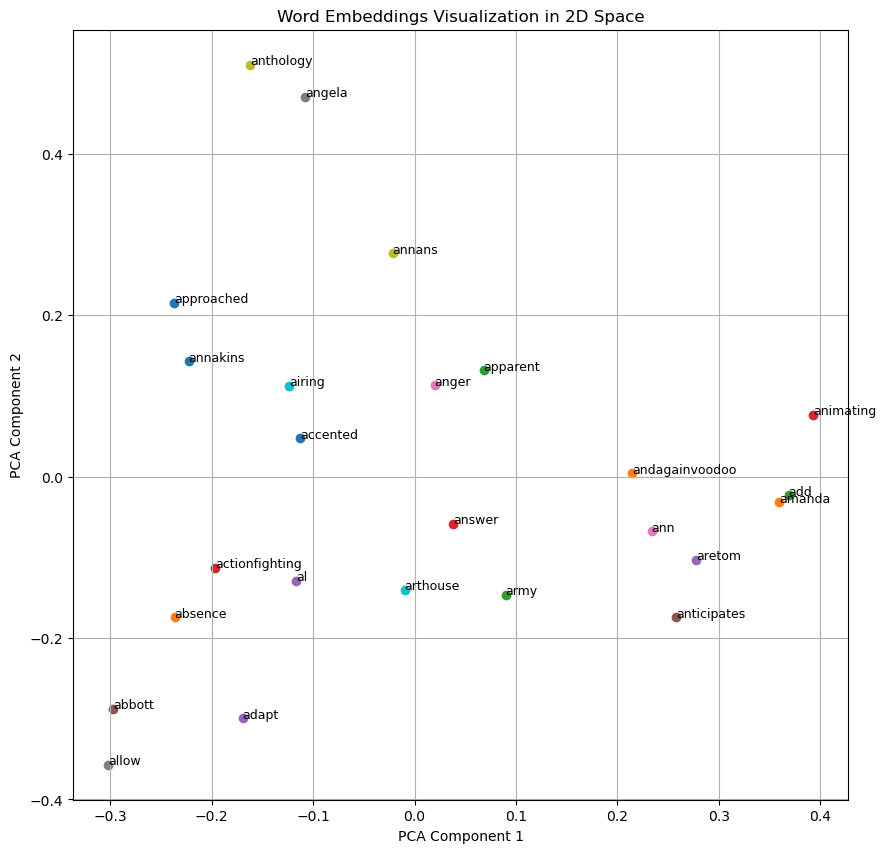

In [528]:
# Plot the embeddings in 2D space
plt.figure(figsize=(10, 10))
for i, word in enumerate(X_pca):
    plt.scatter(X_pca[i, 0], X_pca[i, 1])

plt.title("Word Embeddings Visualization in 2D Space")
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.grid(True)
for i, txt in enumerate(subset_features):
    plt.annotate(txt, (X_pca[i, 0], X_pca[i, 1]), fontsize=9)

plt.show()